## Общая информация

**Срок сдачи:** 5 апреля 2022, 08:30 

**Штраф за опоздание:** по 1 баллу за 24 часа задержки. Через 5 дней домашнее задание сгорает.

При отправлении ДЗ указывайте фамилию в названии файла
Присылать ДЗ необходимо в виде ссылки на свой github репозиторий на почту ml1.sphere@mail.ru с указанием темы в следующем формате:

[ML0220, Задание 1] Фамилия Имя.

Используйте данный Ipython Notebook при оформлении домашнего задания.


**Штрафные баллы:**

1. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw1.ipynb) -0.5 баллов
2. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -0.5 баллов


In [60]:
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn import datasets
from sklearn.base import BaseEstimator

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KDTree
from scipy.stats import mode
from sklearn.datasets import fetch_openml, fetch_20newsgroups
from sklearn.preprocessing import StandardScaler


### Задание 1 (1 балл)
Реализовать KNN в классе MyKNeighborsClassifier (обязательное условие: точность не ниже sklearn реализации)
Разберитесь самостоятельно, какая мера расстояния используется в KNeighborsClassifier дефолтно и реализуйте свой алгоритм именно с этой мерой. 
Для подсчета расстояний можно использовать функции [отсюда](https://docs.scipy.org/doc/scipy/reference/spatial.distance.html)

In [38]:
def distCosine (vecA, vecB):
    def dotProduct (vecA, vecB):
        d = 0.0
        for dim in vecA:
            if dim in vecB:
                d += vecA[dim]*vecB[dim]
        return d
    return np.dot(vecA,vecB) / np.sqrt(dotProduct(vecA,vecA)) / np.sqrt(dotProduct(vecB,vecB))


class MyKNeighborsClassifier(BaseEstimator): 
    x_train = np.array([])
    y_train = np.array([])
    n_neighbors = 0
    algorithm = "brute"
    distance = "evklid"
    def __init__(self, n_neighbors, algorithm='brute', distance = "evklid"):
        self.n_neighbors = n_neighbors
        if (algorithm == 'kd_tree'):
            self.algorithm = "kd_tree"
        if (distance == "cos"):
            self.distance = "cos"
            pass

    def fit(self, X, y):
        self.x_train = X
        self.y_train = y
        pass
    
    def predict(self, X):
        if (self.algorithm == "brute"):
            predictions = []
            for x_test in X:
                if (self.distance == "evklid"):
                    distances = np.sum(np.square(self.x_train - x_test), axis=1)
                else:
                    distances = pairwise_distances(self.x_train, np.repeat(x_test.reshape(1, -1), self.x_train.shape[0], axis=0), metric='cosine')
                min_index_proto = distances.argsort()
                min_index = min_index_proto[:self.n_neighbors]
                y_pred_k = y_train[min_index]
                y_pred = np.asarray(np.unique(y_pred_k, return_counts=True))
                y_pred = np.sort(y_pred, axis=1)
                predictions.append(y_pred[0][0])
        else:
            predictions = []
            tree = KDTree(self.x_train)
            dist, ind = tree.query(X, k=self.n_neighbors)
            y_pred_k = y_train[ind]

            val, count = mode(y_pred_k, axis=1)
            predictions = val.reshape(-1)
            
        return np.array(predictions)    

**IRIS**

В библиотеке scikit-learn есть несколько датасетов из коробки. Один из них [Ирисы Фишера](https://ru.wikipedia.org/wiki/%D0%98%D1%80%D0%B8%D1%81%D1%8B_%D0%A4%D0%B8%D1%88%D0%B5%D1%80%D0%B0)

In [39]:
iris = datasets.load_iris()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [41]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='brute')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='brute')

In [42]:
clf.fit(X_train, y_train)
my_clf.fit(X_train, y_train)

In [43]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 2 (0.5 балла)

Давайте попробуем добиться скорости работы на fit, predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. 

In [44]:
%time clf.fit(X_train, y_train)

CPU times: user 867 µs, sys: 353 µs, total: 1.22 ms
Wall time: 837 µs


KNeighborsClassifier(algorithm='brute', n_neighbors=2)

In [45]:
%time my_clf.fit(X_train, y_train)

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 6.44 µs


In [46]:
%time clf.predict(X_test)

CPU times: user 1.44 ms, sys: 4.73 ms, total: 6.17 ms
Wall time: 4.56 ms


array([0, 0, 0, 1, 2, 2, 1, 1, 1, 0, 2, 0, 2, 2, 1])

In [47]:
%time my_clf.predict(X_test)

CPU times: user 1.21 ms, sys: 0 ns, total: 1.21 ms
Wall time: 986 µs


array([0, 0, 0, 1, 2, 2, 1, 1, 1, 0, 2, 0, 2, 2, 1])

### Задание 3 (1 балл)
Добавьте algorithm='kd_tree' в реализацию KNN (использовать KDTree из sklearn.neighbors). Необходимо добиться скорости работы на fit,  predict сравнимой со sklearn для iris. Допускается замедление не более чем в 2 раза. 
Для этого используем numpy. Точность не должна уступать значению KNN из sklearn. 

In [48]:
clf = KNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')
my_clf = MyKNeighborsClassifier(n_neighbors=2, algorithm='kd_tree')

In [49]:
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.1, stratify=iris.target)

In [50]:
%time clf.fit(X_train, y_train)

CPU times: user 2.54 ms, sys: 0 ns, total: 2.54 ms
Wall time: 1.86 ms


KNeighborsClassifier(algorithm='kd_tree', n_neighbors=2)

In [51]:
%time my_clf.fit(X_train, y_train)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.2 µs


In [52]:
%time clf.predict(X_test)

CPU times: user 2.52 ms, sys: 1.02 ms, total: 3.54 ms
Wall time: 2.28 ms


array([1, 0, 2, 0, 1, 1, 1, 0, 2, 1, 0, 2, 2, 2, 0])

In [53]:
%time my_clf.predict(X_test)

CPU times: user 1.9 ms, sys: 3.23 ms, total: 5.13 ms
Wall time: 3.6 ms


array([1, 0, 2, 0, 1, 1, 1, 0, 2, 1, 0, 2, 2, 2, 0])

In [54]:
sklearn_pred = clf.predict(X_test)
my_clf_pred = my_clf.predict(X_test)
assert abs( accuracy_score(y_test, my_clf_pred) -  accuracy_score(y_test, sklearn_pred ) )<0.005, "Score must be simillar"

### Задание 4 (2.5 балла)

Рассмотрим новый датасет 20 newsgroups

In [56]:
newsgroups = fetch_20newsgroups(subset='train',remove=['headers','footers', 'quotes'])

In [57]:
data = newsgroups['data']
target = newsgroups['target']

Преобразуйте текстовые данные из data с помощью [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Словарь можно ограничить по частотности.

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=5)
X = vectorizer.fit_transform(data).toarray()
Y = target
X = X[:,:100:]
print(X.shape)
print(Y.shape)

(11314, 100)
(11314,)


*Так мы получили векторное представление наших текстов. Значит можно приступать к задаче обучения модели*

Реализуйте разбиение выборки для кросс-валидации на 3 фолдах. Разрешено использовать sklearn.cross_validation

In [59]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X):
    X_tr_va, X_test = X[train_index], X[test_index]
    y_tr_va, y_test = Y[train_index], Y[test_index]
    X_train, X_val, y_train, y_val = train_test_split(X_tr_va, y_tr_va)

Напишите метод, позволяющий найти оптимальное количество ближайших соседей(дающее максимальную точность в среднем на валидации на 3 фолдах).
Постройте график зависимости средней точности от количества соседей. Можно рассмотреть число соседей от 1 до 10.

In [61]:
a = np.array([1, 2, 3, 4])
b = np.array([])
for k in  range(4):
    b = np.append(np.array([b]), np.array(a[k]))
print(b)

[1. 2. 3. 4.]


In [62]:
max_accuracy = 0
k1 = 0
accuracy_vector = np.array([])
kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X):
    X_train, X_val, y_train, y_val = X[train_index], X[test_index], Y[train_index], Y[test_index]
    X_train = StandardScaler().fit(X_train).transform(X_train)
    X_val = StandardScaler().fit(X_val).transform(X_val)
    accuracy_vector = np.array([])
    for k in range(1, 25):
        my_clf = MyKNeighborsClassifier(n_neighbors=k, algorithm='brute')
        my_clf.fit(X_train, y_train)
        my_clf_pred = my_clf.predict(X_val)
        accuracy = accuracy_score(y_val, my_clf_pred)
        accuracy_vector = np.append(np.array(accuracy_vector), np.array(accuracy))
        if (max_accuracy < accuracy):
            max_accuracy = accuracy
            k1 = k
print(k1, max_accuracy)
print(accuracy_vector)

1 0.0562185096791302
[0.05621851 0.05621851 0.05621851 0.05330151 0.05330151 0.05330151
 0.05303633 0.05303633 0.05303633 0.05303633 0.05303633 0.05303633
 0.05303633 0.05303633 0.05303633 0.05303633 0.05303633 0.05303633
 0.05303633 0.05303633 0.04428534 0.04428534 0.04428534 0.04428534]


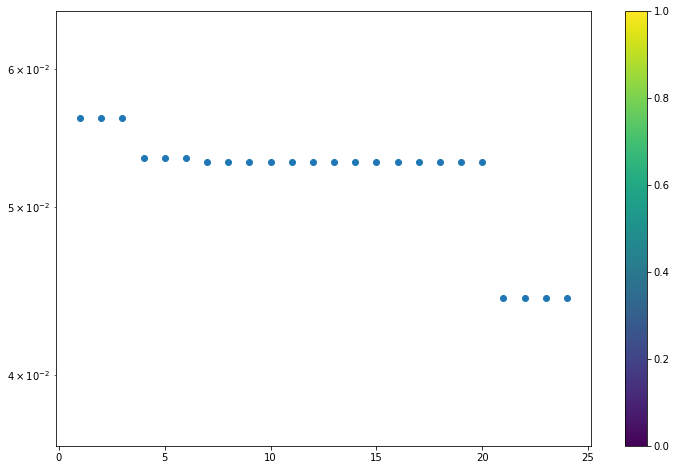

In [63]:
import matplotlib.pyplot as plt

k_vector = np.arange(1, 25)
gridsize = (1, 1)
fig = plt.figure(figsize=(12, 8))
ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=2, rowspan=2)
sctr = ax1.scatter(x=k_vector, y=accuracy_vector, cmap='RdYlGn')
plt.colorbar(sctr, ax=ax1)
ax1.set_yscale('log')

In [64]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_df=5)
X = vectorizer.fit_transform(data).toarray()
Y = target
X = X[:,:100:]
print(X.shape)
print(Y.shape)
max_accuracy = 0
k1 = 0
kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X):
    X_train, X_val, y_train, y_val = X[train_index], X[test_index], Y[train_index], Y[test_index]
    X_train = StandardScaler().fit(X_train).transform(X_train)
    X_val = StandardScaler().fit(X_val).transform(X_val)
    for k in range(1, 25):
        my_clf = MyKNeighborsClassifier(n_neighbors=k, algorithm='brute')
        my_clf.fit(X_train, y_train)
        my_clf_pred = my_clf.predict(X_val)
        accuracy = accuracy_score(y_val, my_clf_pred)
        if (max_accuracy < accuracy):
            max_accuracy = accuracy
            k1 = k
print(k1, max_accuracy)

(11314, 100)
(11314,)
1 0.0562185096791302


Как изменится качество на валидации, если:

1. Используется косинусная метрика вместо евклидовой.
2. К текстам применяется TfIdf векторизацию( sklearn.feature_extraction.text.TfidfVectorizer)

Сравните модели, выберите лучшую.

Загрузим  теперь test  часть нашей выборки и преобразуем её аналогично с train частью. Не забудьте, что наборы слов в train и test части могут отличаться.

In [65]:
newsgroups = fetch_20newsgroups(subset='test',remove=['headers','footers', 'quotes'])

Оценим точность вашей лучшей модели на test части датасета. Отличается ли оно от кросс-валидации? Попробуйте сделать выводы, почему отличается качество.

In [66]:
data = newsgroups['data']
target = newsgroups['target']
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_df=5)
X = vectorizer.fit_transform(data).toarray()
Y = target
X = X[:,:100:]
print(X.shape)
print(Y.shape)
max_accuracy = 0
k1 = 0
kf = KFold(n_splits=3)
for train_index, test_index in kf.split(X):
    X_train, X_val, y_train, y_val = X[train_index], X[test_index], Y[train_index], Y[test_index]
    for k in range(1, 25):
        my_clf = MyKNeighborsClassifier(n_neighbors=k, algorithm='brute')
        my_clf.fit(X_train, y_train)
        my_clf_pred = my_clf.predict(X_val)
        accuracy = accuracy_score(y_val, my_clf_pred)
        if (max_accuracy < accuracy):
            max_accuracy = accuracy
            k1 = k
print(k1, max_accuracy)

(7532, 100)
(7532,)
4 0.05856573705179283
